In [1]:
# Strategy 1: 
'''
Training a models with the groundtruth image generated in almost empty parking lots with object detection YOLO8

Step 1: Detecting the images which has almost all empty spaces in the pklot data and the corresponding data in the empty folder and collect it into a different data set
Strp 2: 


Methods of interest:

1) Convolutional Neural Networks (CNNs):
CNNs are widely used for image-related tasks, including object detection. Architectures like YOLO (You Only Look Once), Faster R-CNN (Region-based Convolutional Neural Network), and SSD (Single Shot Multibox Detector) are popular choices.
These models can be trained on a dataset containing images of car lots with corresponding annotations for parking spaces.

2) Transfer Learning:
Transfer learning involves using a pre-trained model on a large dataset and fine-tuning it for your specific task. This is particularly useful when you have a limited amount of data.
Models pre-trained on large image datasets, such as ImageNet, can be fine-tuned for parking space detection.

3) Mask R-CNN:
Mask R-CNN is an extension of Faster R-CNN that also provides segmentation information for each detected object. This means it can not only detect parking spaces but also outline their boundaries.
'''

'\nTraining a models with the groundtruth image generated in almost empty parking lots with object detection YOLO8\n\nStep 1: Detecting the images which has almost all empty spaces in the pklot data and the corresponding data in the empty folder and collect it into a different data set\nStrp 2: \n\n\nMethods of interest:\n\n1) Convolutional Neural Networks (CNNs):\nCNNs are widely used for image-related tasks, including object detection. Architectures like YOLO (You Only Look Once), Faster R-CNN (Region-based Convolutional Neural Network), and SSD (Single Shot Multibox Detector) are popular choices.\nThese models can be trained on a dataset containing images of car lots with corresponding annotations for parking spaces.\n\n2) Transfer Learning:\nTransfer learning involves using a pre-trained model on a large dataset and fine-tuning it for your specific task. This is particularly useful when you have a limited amount of data.\nModels pre-trained on large image datasets, such as ImageNet

In [2]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import numpy as np
import pandas as pd
import cv2

In [3]:
#yolo_model = YOLO("../models/yolov8x.pt")

## Generate segmented images of empty parking lots => PKLotSegmented_empty

In [4]:
'''
# paths for empty images import 
DATASET_PATH_RAW = "../data/PKLot/PKLotSegmented/UFPR05/Rainy/"
DEST_PATH = "../data/PKLot/PKLotSegmented_empty/UFPR05/Rainy/"

# importing the listof dates from the directory name
daylist = os.listdir(DATASET_PATH_RAW)

for day in daylist:
    daypath = os.path.join(DATASET_PATH_RAW, day)
    path = os.path.join(daypath, 'Empty')
    if os.path.exists(path):
        filelist = os.listdir(path)
        for file in filelist:
            filepath = os.path.join(path,file)
            shutil.copy(filepath,DEST_PATH)
        else:
            print(f'path {path} empty')

'''

'\n# paths for empty images import \nDATASET_PATH_RAW = "../data/PKLot/PKLotSegmented/UFPR05/Rainy/"\nDEST_PATH = "../data/PKLot/PKLotSegmented_empty/UFPR05/Rainy/"\n\n# importing the listof dates from the directory name\ndaylist = os.listdir(DATASET_PATH_RAW)\n\nfor day in daylist:\n    daypath = os.path.join(DATASET_PATH_RAW, day)\n    path = os.path.join(daypath, \'Empty\')\n    if os.path.exists(path):\n        filelist = os.listdir(path)\n        for file in filelist:\n            filepath = os.path.join(path,file)\n            shutil.copy(filepath,DEST_PATH)\n        else:\n            print(f\'path {path} empty\')\n\n'

In [5]:
DATASET_PATH_pklot = "../data/PKLot/PKLot/PUCPR/Sunny/"
DEST_PATH = "../data/PKLot/PKLotSegmented_empty/PUC/Sunny/"

In [6]:
# Display some files there:
date_time_file_list = os.listdir(DEST_PATH)

# trim the files names and get the unique whole image by the date
date_time_trimmed_list = [ (x.split('#'))[0].strip() for x in date_time_file_list]

# Generate the list of dates that is unique 
date_list = list(set(date_time_trimmed_list))  


## Observe only one image in one day

In [7]:
img = date_list[1]
img_xml = img + '.xml'

In [8]:
img_xml

'2012-09-13_12_40_23.xml'

In [9]:
date = img[:10]
image_file = date + img[10:]+'.jpg'
image_file

'2012-09-13_12_40_23.jpg'

In [10]:
def show_image(image, title = 'Title'):
    plt.figure(figsize=(20,15))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [11]:
# Function to print groundtruth on a image
def mod_print_ground_truth(path , ground_truth , image):

    # Read the image with opencv
    imgocv = cv2.cvtColor(cv2.imread(os.path.join(path,image)), cv2.COLOR_BGR2RGB)

    # Specify the path to ground truth .xml
    xml_file_path = os.path.join(path,ground_truth)

    # Parse the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    bounding_boxes = []

    # Iterate over each space in the parking lot
    for space_element in root.findall('.//space'):
        space_id = space_element.get('id')
        occupied = space_element.get('occupied')
        center = space_element.find('.//rotatedRect/center')
        center_x = int(float(center.get('x')))
        center_y = int(float(center.get('y')))

        # Attempt to find the <contour> element directly under <space>
        contour_element = space_element.find('.//contour')
        
        if contour_element is not None:
            # Attempt to find <point> elements under <contour>
            contour_points = contour_element.findall('point')

            # Convert the list of points to a numpy array
            points_array = np.array([(int(point.get('x')), int(point.get('y'))) for point in contour_points], dtype=np.int32)

            # Check if enough points are available
            if len(points_array) >= 3:
                # Calculate the bounding box coordinates
                rect = cv2.minAreaRect(points_array)
                box = cv2.boxPoints(rect)
                box = box.astype(int)

                if occupied == '0':
                    bounding_boxes.append(box)
                    # Draw the bounding box on the copied image
                    cv2.drawContours(imgocv, [box], 0, (0, 255, 0), 2)
            else:
                print("Error: Not enough points for bounding box.")
        else:
            print("Error: <contour> element not found for the space.")

    return imgocv, bounding_boxes

In [12]:
img_path = os.path.join(DATASET_PATH_pklot,date)
img_path

'../data/PKLot/PKLot/PUCPR/Sunny/2012-09-13'

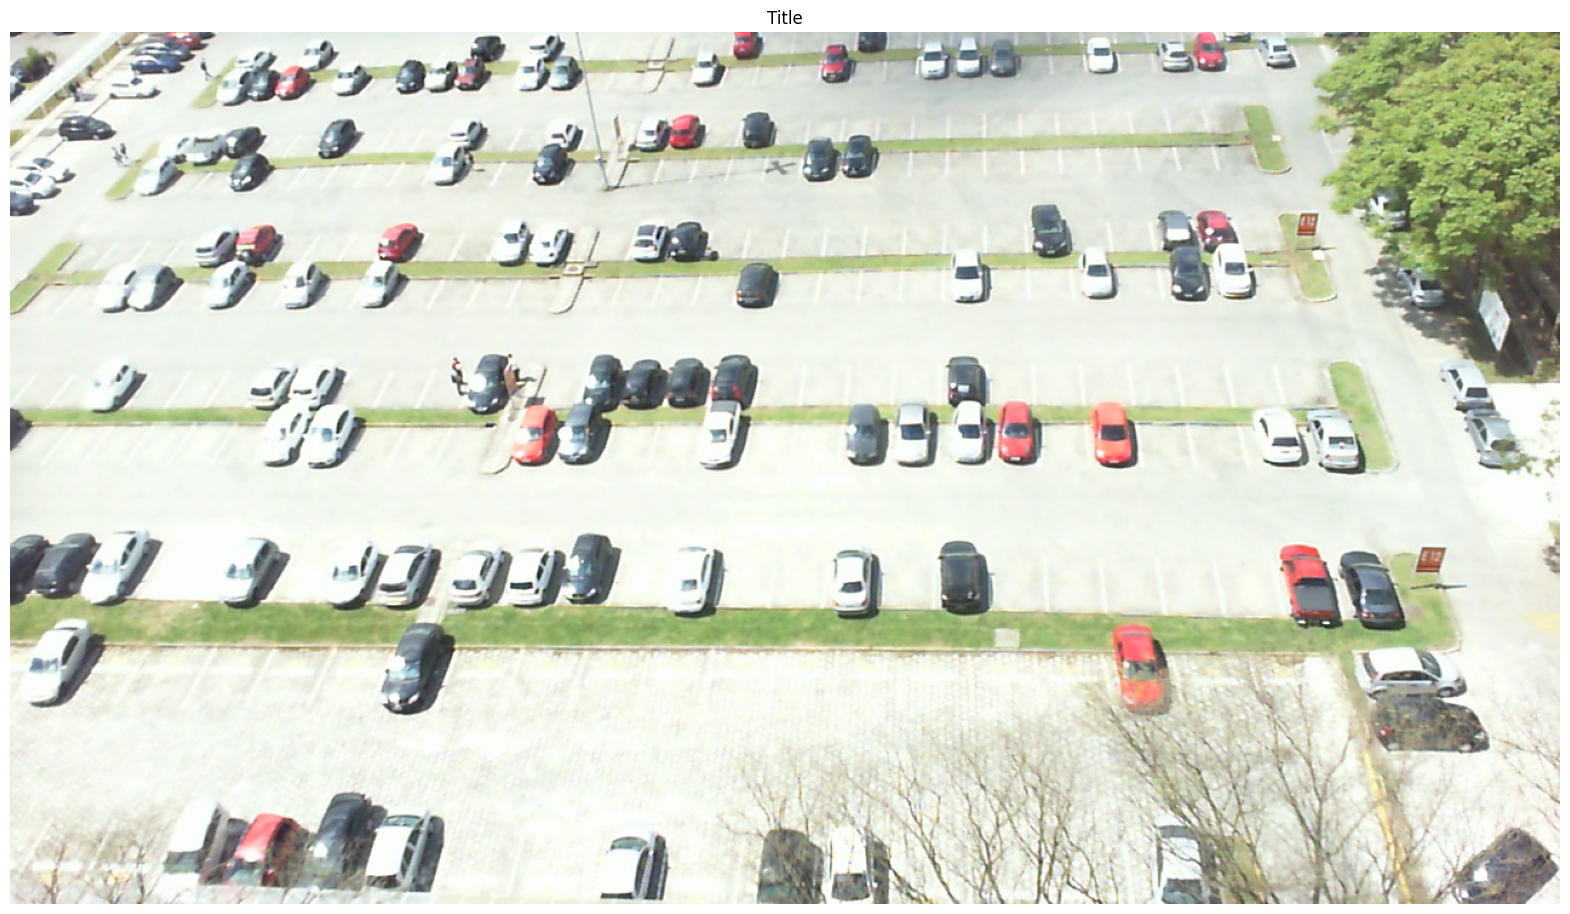

In [13]:
image = cv2.cvtColor(cv2.imread(os.path.join(img_path,image_file)), cv2.COLOR_BGR2RGB)
show_image(image)

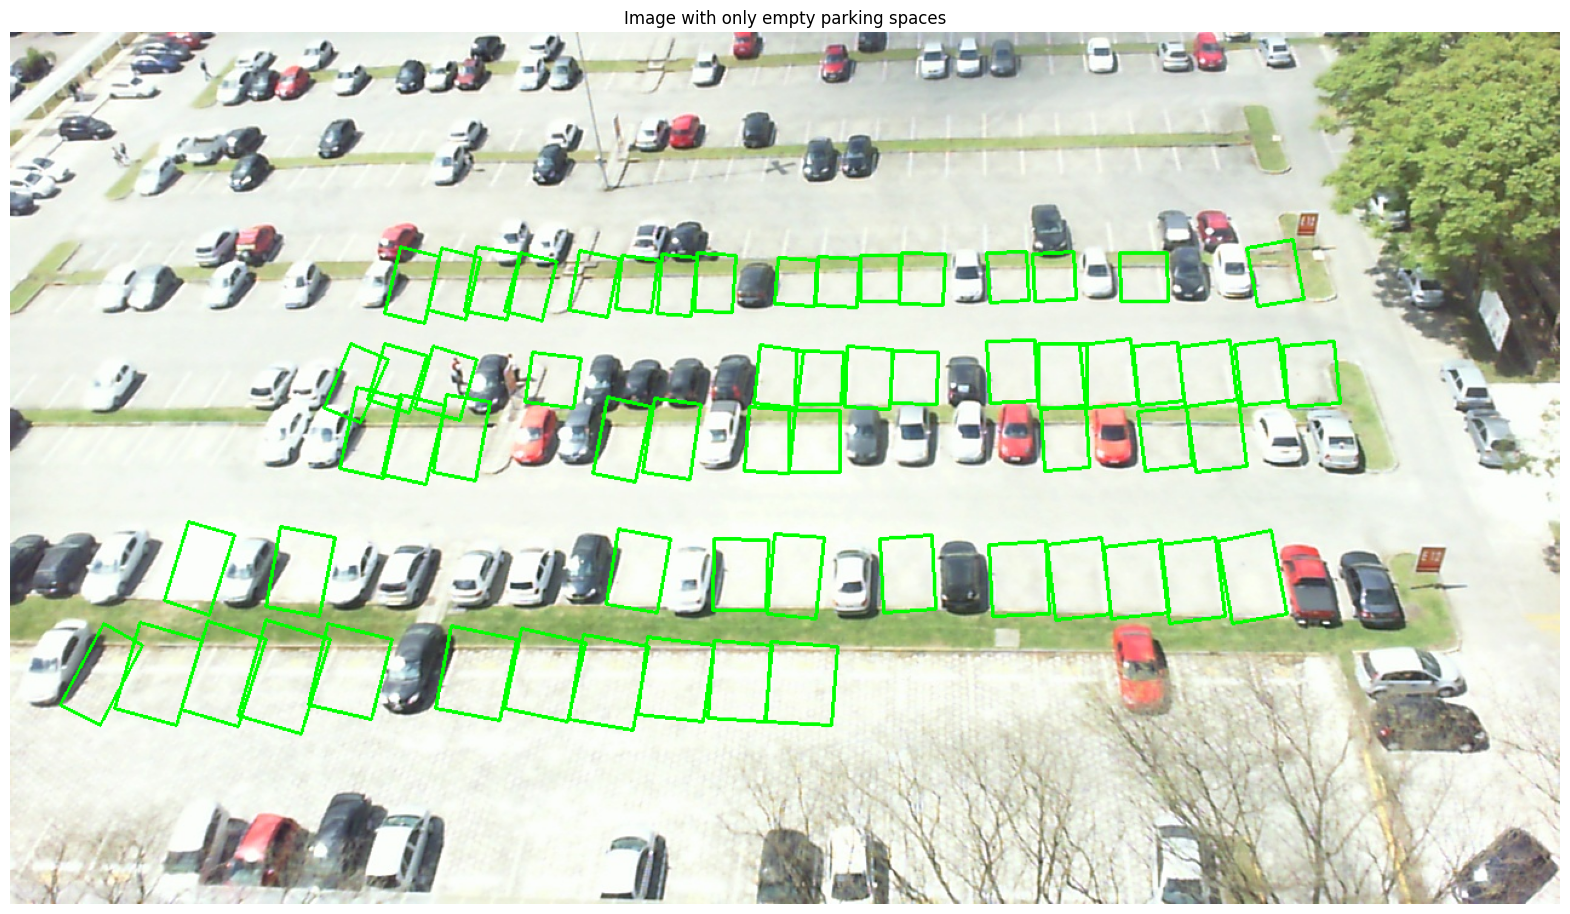

In [14]:
img_xml_path = img_path+'/'
grnd_tth_image, _ = mod_print_ground_truth(img_xml_path , img_xml , image_file)
show_image(grnd_tth_image, title='Image with only empty parking spaces')

## Generate Empty catlot images with non-occupied ground-truth => PKLot_Non_Occupied

In [15]:
# function to generate all the above images in a function: Generate an image with 
def generate_non_empty_GT(img_date_time, source_path):
    img = img_date_time
    img_xml = img + '.xml'
    date = img[:10]     # extarct the date from the 'date#time' format
    image_file = date + img[10:]+'.jpg'

    img_path = os.path.join(source_path,date)
    img_xml_path = img_path+'/'
    grnd_tth_image, _ = mod_print_ground_truth(img_xml_path , img_xml , image_file)

    return grnd_tth_image

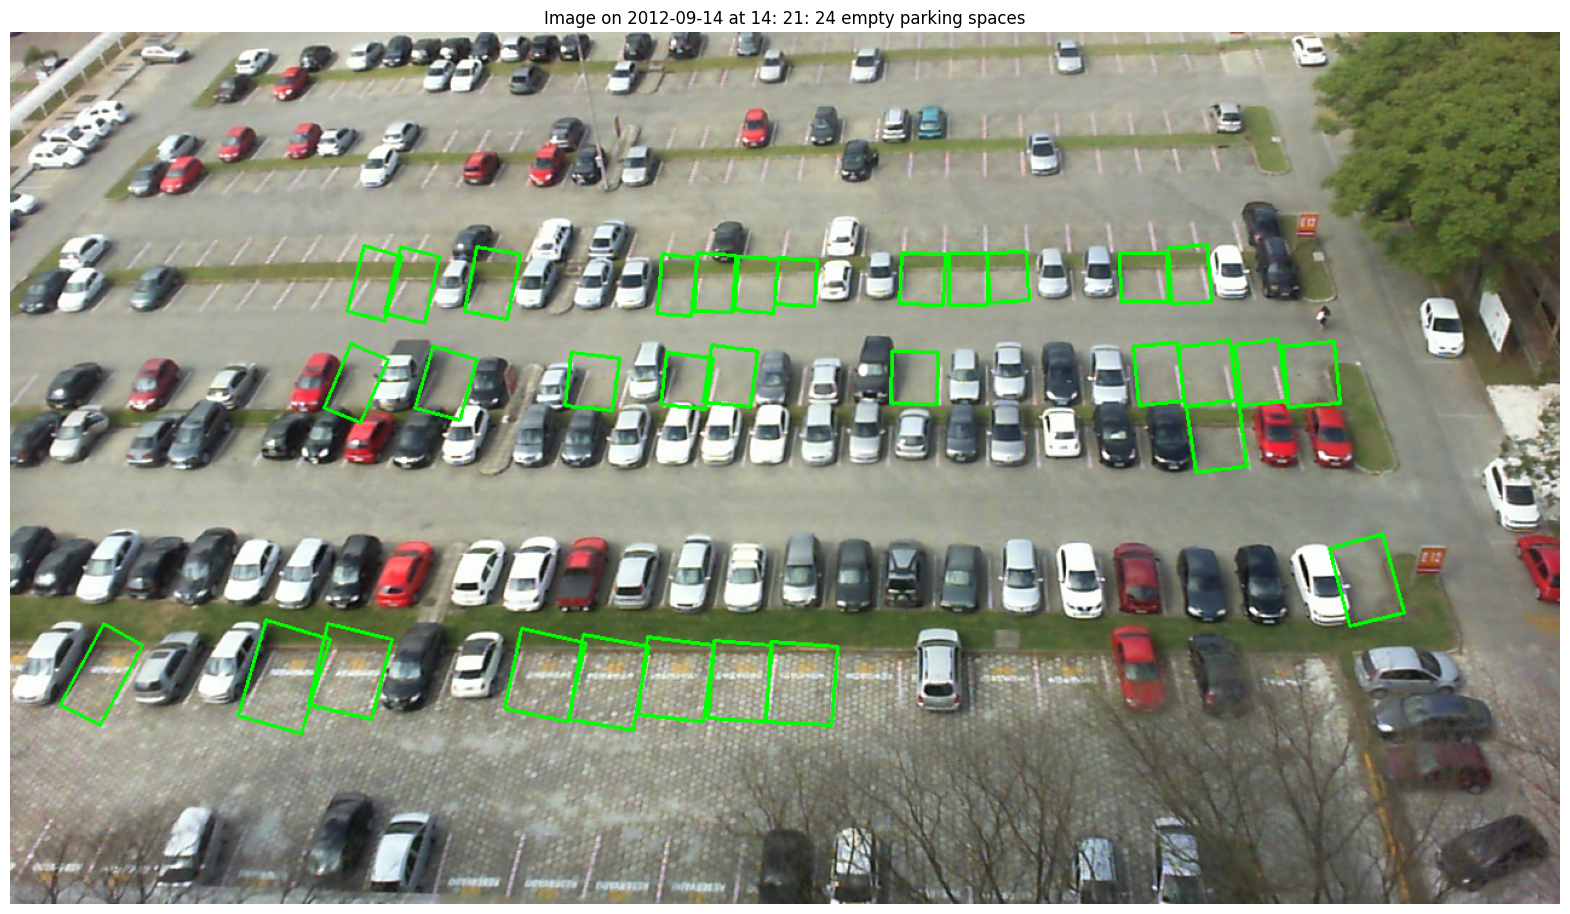

In [21]:
# testing the function
image_index = 10
img_time = f'{date_list[image_index][11:13]}: {date_list[image_index][14:16]}: {date_list[image_index][17:]}'
show_image(generate_non_empty_GT(date_list[image_index], DATASET_PATH_pklot), title=f'Image on {date_list[image_index][:10]} at {img_time} empty parking spaces')

## Generating 'PKLot_Non_Occupied' data-set

In [17]:
'''

# paths for empty images import 
DATASET_PATH_RAW = "../data/PKLot/PKLot/UFPR05/Rainy/"
SOURCE_PATH = "../data/PKLot/PKLotSegmented_empty/UFPR05/Rainy/"
SAVE_PATH = "../data/PKLot/PKLot_Non_occupied/UFPR05/Rainy/"

# Display some files there:
date_time_file_list = os.listdir(SOURCE_PATH)

# trim the files names and get the unique whole image by the date
date_time_trimmed_list = [ (x.split('#'))[0].strip() for x in date_time_file_list]

# Generate the list of dates that is unique 
date_list = list(set(date_time_trimmed_list))  # => list of unique data folders in 'SOURCE_PATH' -> will be folder names in 'DATASET_PATH_RAW'

for day in date_list:
    daypath = os.path.join(DATASET_PATH_RAW, day[:10])
    
    if os.path.exists(daypath):
        gt_image_array = generate_non_empty_GT(day, DATASET_PATH_RAW)
        #show_image(gt_image)

        # Convert NumPy array to PIL Image (only for the saving purposes)
        gt_image = Image.fromarray(np.uint8(gt_image_array))

        # Save the gt_image with the name as 'day.jpg' in the SAVE_PATH
        save_path = os.path.join(SAVE_PATH, f"{day}.jpg")
        gt_image.save(save_path)
        print(f'Image {day}.jpg is saved successfully!')    
         
'''

'\n\n# paths for empty images import \nDATASET_PATH_RAW = "../data/PKLot/PKLot/UFPR05/Rainy/"\nSOURCE_PATH = "../data/PKLot/PKLotSegmented_empty/UFPR05/Rainy/"\nSAVE_PATH = "../data/PKLot/PKLot_Non_occupied/UFPR05/Rainy/"\n\n# Display some files there:\ndate_time_file_list = os.listdir(SOURCE_PATH)\n\n# trim the files names and get the unique whole image by the date\ndate_time_trimmed_list = [ (x.split(\'#\'))[0].strip() for x in date_time_file_list]\n\n# Generate the list of dates that is unique \ndate_list = list(set(date_time_trimmed_list))  # => list of unique data folders in \'SOURCE_PATH\' -> will be folder names in \'DATASET_PATH_RAW\'\n\nfor day in date_list:\n    daypath = os.path.join(DATASET_PATH_RAW, day[:10])\n    \n    if os.path.exists(daypath):\n        gt_image_array = generate_non_empty_GT(day, DATASET_PATH_RAW)\n        #show_image(gt_image)\n\n        # Convert NumPy array to PIL Image (only for the saving purposes)\n        gt_image = Image.fromarray(np.uint8(gt_im

## Train baseline model to Train Object detection model

In [18]:
#%pip install tensorflow

In [22]:
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

ModuleNotFoundError: No module named 'object_detection'